# Process Throughput Scaling Results

## Imports, Utils, Cfg, Etc

In [1]:
import itertools
import datetime
import glob
import os
import shutil
from statistics import median
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
ROOT_DIR = Path("/lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling")
RESULTS_DIR = ROOT_DIR / "official-loop-time"
PROCESSED_RESULTS_DIR = RESULTS_DIR / "my_results"
FORCE_RELOAD = False

In [3]:
sns.set_palette('colorblind')

## Agreed upon axis for study w/ Dragon

In [4]:
ax_client_nodes = [1, 16, 32, 64, 128]
ax_clients_per_node = [1, 8, 16, 32, 64]
ax_db_nodes = [8, 16, 32]
ax_db_cpus = [36]

# dragon pool does well up to 64
ax_tensor_bytes = [8, 16, 32, 1_024, 8_192, 16_384, 32_768, 65_536, 131_072, 262_144, 524_288, 1_048_576]
# ax_tensor_bytes = [1_024, 8_192, 16_384, 32_769,65_538, 131_076, 262_152, 524_304, 1_024_000]

# dragon has managers
# we do not for redis :(
# if time for key db set number of threads
# num_dragon_managers = [1, 2, 4]

ax_iterations = [100]

## Agregate Findings Across MPI Ranks

### Load in Raw Data from Study

In [5]:
def open_and_add_ctx_to_out_file(
    csv_file_path,
    client_nodes,
    clients_per_node,
    db_nodes,
    db_cpus,
    tensor_bytes,
    iterations
):
    df = pd.read_csv(csv_file_path, index_col=None, names=["Rank", "Action", "Time (Seconds)"])
    return df

def aggregate_action_data_in_df(df):
    action_groups = df[["Action", "Time (Seconds)"]].groupby("Action")
    agg_data = {}
    for action, data in action_groups:
        times = data["Time (Seconds)"]
        agg_data.update({
            f"{action}_min": times.min(),
            f"{action}_mean": times.mean(),
            f"{action}_max": times.max()
        })
    return agg_data

In [6]:
def process_throughput_out_data(results_dir, processed_dir):
    composite_data = []
    agg_data = []
    for    client_nodes,    clients_per_node,    db_nodes,    db_cpus,    tensor_bytes,    iterations in tqdm(list(itertools.product(
        ax_client_nodes, ax_clients_per_node, ax_db_nodes, ax_db_cpus, ax_tensor_bytes, ax_iterations
    )), desc="Processing scaling results...", ncols=80):
        scale_out_dir = \
            f"throughput-sess-python-N{client_nodes}-T{clients_per_node}-DBN{db_nodes}-DBCPU{db_cpus}-ITER{iterations}-TB{tensor_bytes}-*"
        try:
            dir_, *other = glob.iglob(str(results_dir / scale_out_dir))
        except ValueError:
            print(f"Failed to find {scale_out_dir}")
            continue
        else:
            if other:
                print(f"WARNING: got extra, unexpected results dirs: {other};\n"
                       "         Ignoring for now!!")
        dfs = (
            open_and_add_ctx_to_out_file(
                str(csv),
                client_nodes,
                clients_per_node,
                db_nodes,
                db_cpus,
                tensor_bytes,
                iterations
            )
            for csv in glob.iglob(os.path.join(dir_, "rank_*_timing.csv"))
        )
        ranks_data_df = pd.concat(dfs, ignore_index=True)
        assert len(pd.unique(ranks_data_df["Rank"])) == client_nodes * clients_per_node

        specs = {
            "client_nodes": client_nodes,
            "clients_per_node": clients_per_node,
            "database_nodes": db_nodes,
            "database_cpus": db_cpus,
            "iterations": iterations,
            "tensor_bytes": tensor_bytes,
        }
        composite_data.append(ranks_data_df.assign(**specs))
        # agg_data.append(pd.DataFrame([{
        #     **specs,
        #     **aggregate_action_data_in_df(ranks_data_df),
        # }]))

    composite_df = pd.concat(composite_data, ignore_index=True)
    # agg_df = pd.concat(agg_data, ignore_index=True)

    composite_df.to_csv(str(processed_dir / "composite.csv"), index=False)
    # agg_df.to_csv(str(processed_dir / "processed.csv"), index=False)
    return composite_df # , agg_df

def load_from_disk(res_dir):
    return pd.read_csv(str(res_dir / "composite.csv"), index_col=None)
            # pd.read_csv(str(res_dir / "processed.csv"), index_col=None))

if PROCESSED_RESULTS_DIR.is_dir() and not FORCE_RELOAD:
    print(f"Processed results dir {PROCESSED_RESULTS_DIR} detected!")
    print("Loading data from disk")
    composite_df = load_from_disk(PROCESSED_RESULTS_DIR)
else:
    print("Processing and writing data to disk")
    shutil.rmtree(PROCESSED_RESULTS_DIR, ignore_errors=True)
    PROCESSED_RESULTS_DIR.mkdir()
    composite_df = process_throughput_out_data(RESULTS_DIR, PROCESSED_RESULTS_DIR)

Processed results dir /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/my_results detected!
Loading data from disk


In [7]:
composite_df

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
0,0,client(),0.008124,1,1,8,36,100,8
1,0,put_tensor,0.004406,1,1,8,36,100,8
2,0,unpack_tensor,0.002802,1,1,8,36,100,8
3,0,main(),0.018920,1,1,8,36,100,8
4,0,client(),0.007683,1,1,8,36,100,16
...,...,...,...,...,...,...,...,...,...
3920395,1625,main(),47.859204,128,64,32,36,100,1048576
3920396,4693,client(),0.047252,128,64,32,36,100,1048576
3920397,4693,put_tensor,10.926278,128,64,32,36,100,1048576
3920398,4693,unpack_tensor,14.853223,128,64,32,36,100,1048576


## Plot Findings

In [8]:
nodes_and_client_per_node_to_data = {
    n_and_cpn: df for n_and_cpn, df 
    in (composite_df[composite_df["database_cpus"] == 36]
        .groupby(['client_nodes', 'clients_per_node']))
}

In [9]:
NODES = 32
CLIENTS_PER_NODE = 32
ITERATIONS = 100

def make_throughput_per_client_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: (
            (
                (msg_size * ITERATIONS)   # number of bytes moved by each rank
                / group['Time (Seconds)'] # divided by time for rank to complete
            ).mean() # Average across all ranks
            / 1e9  # bytes -> gigs
        )
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

def make_observed_throughput_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: ((msg_size * ITERATIONS * NODES * CLIENTS_PER_NODE)  # Number of bytes moved within time limit
            / group['Time (Seconds)'].max()  # divied by time for all ranks to reach barrier
            / 1e9  # bytes -> gigs
           )
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

plot_data = nodes_and_client_per_node_to_data[(NODES, CLIENTS_PER_NODE)]
client_num_title = f"({NODES} Nodes, {CLIENTS_PER_NODE} Clients per Node)"

### Put Tensor Times

In [10]:
put_tensor_data = plot_data[plot_data["Action"] == "put_tensor"]

In [11]:
put_tensor_data.tail()

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
280061,647,put_tensor,1.992176,32,32,32,36,100,1048576
280065,510,put_tensor,2.636207,32,32,32,36,100,1048576
280069,781,put_tensor,3.003985,32,32,32,36,100,1048576
280073,176,put_tensor,2.006491,32,32,32,36,100,1048576
280077,10,put_tensor,2.563694,32,32,32,36,100,1048576


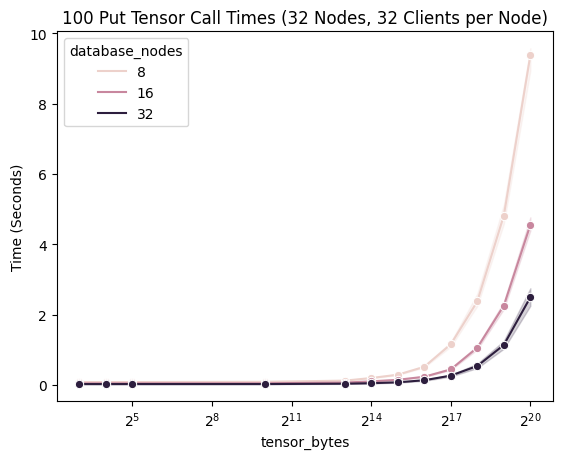

In [12]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

put_call_time_data = put_tensor_data[[x, y, hue]]
plot = sns.lineplot(put_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Put Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)

In [13]:
put_call_time_data

,tensor_bytes,Time (Seconds),database_nodes
132625,8,0.070554,8
132629,8,0.091907,8
132633,8,0.091796,8
132637,8,0.076217,8
132641,8,0.077034,8
...,...,...,...
280061,1048576,1.992176,32
280065,1048576,2.636207,32
280069,1048576,3.003985,32
280073,1048576,2.006491,32


### Put Tensor Throughput Per Client

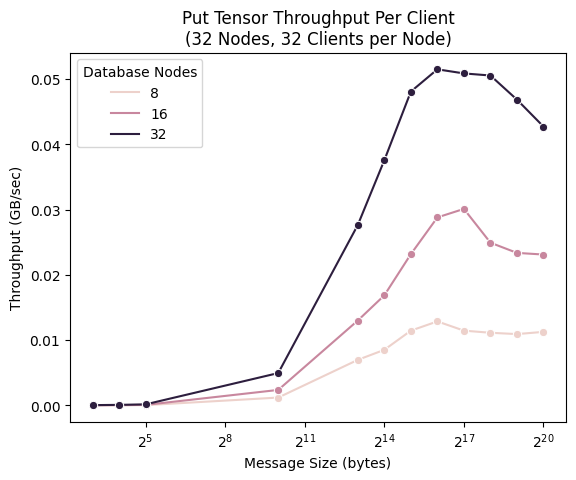

In [14]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

put_throughput_df = make_throughput_per_client_dataset(put_tensor_data, x, y, hue)
plot = sns.lineplot(put_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale("log", base=2)

### Put Tensor Throughput Per DB

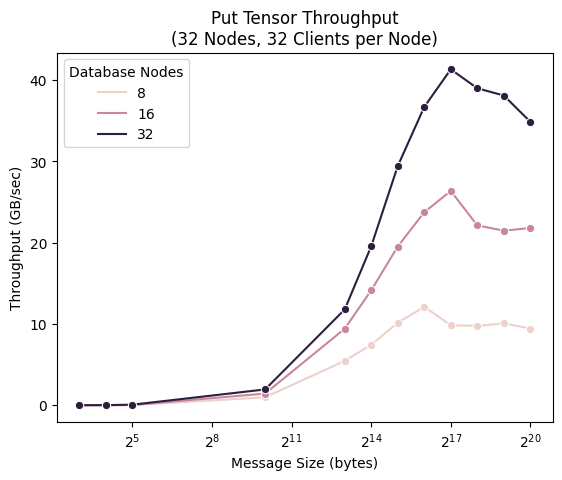

In [15]:
plot = sns.lineplot(make_observed_throughput_dataset(put_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Times

In [16]:
get_tensor_data = plot_data[plot_data["Action"] == "unpack_tensor"]

In [17]:
get_tensor_data.tail()

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
280062,647,unpack_tensor,2.697444,32,32,32,36,100,1048576
280066,510,unpack_tensor,3.364254,32,32,32,36,100,1048576
280070,781,unpack_tensor,3.186683,32,32,32,36,100,1048576
280074,176,unpack_tensor,3.215298,32,32,32,36,100,1048576
280078,10,unpack_tensor,3.164765,32,32,32,36,100,1048576


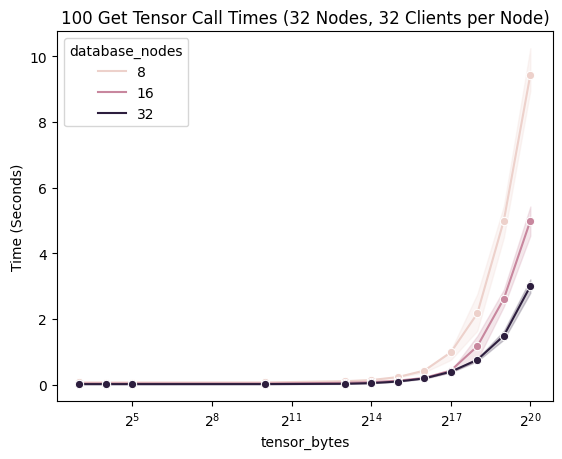

In [18]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

get_call_time_data = get_tensor_data[[x, y, hue]]
plot = sns.lineplot(get_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Get Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)
# plot.set_xticks(ax_tensor_bytes)
# plot.set_yscale('log', base=2)

### Get Tensor Throughput Per Client

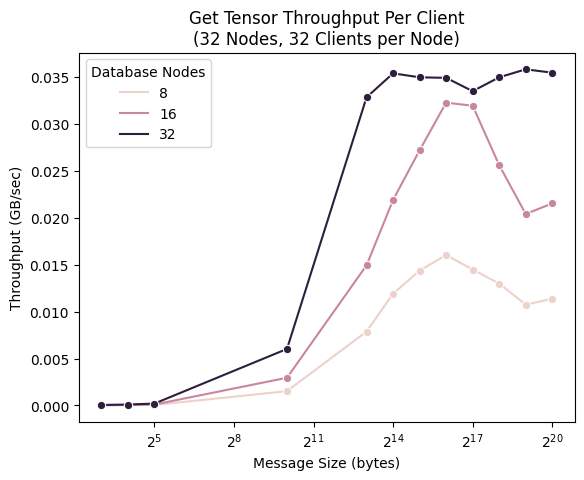

In [19]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

get_throughput_df = make_throughput_per_client_dataset(get_tensor_data, x, y, hue)
plot = sns.lineplot(get_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Throughput Per DB

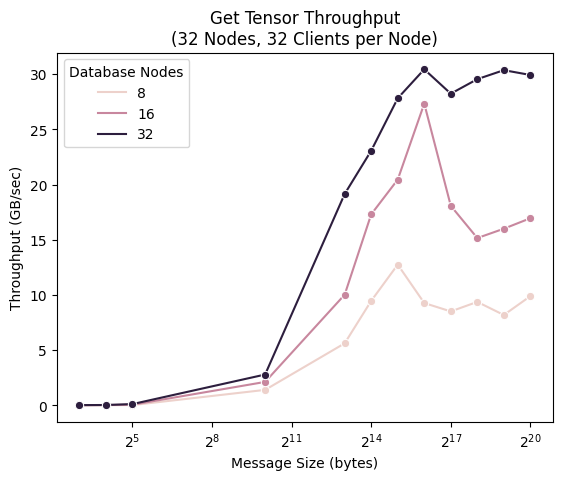

In [20]:
plot = sns.lineplot(make_observed_throughput_dataset(get_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)

In [21]:
# TODO:
# bandwidth per node (throughput per client * clients per node)
# latency per client per op (make histogram)
# throughput per node | fixed tensor -> over different number of nodes